In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']= 15,6

In [3]:
data= pd.read_csv('AirPassengers.csv')

In [5]:
print(data.head())

     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121


In [7]:
print("\n Data types:")
print(data.dtypes)


 Data types:
Month          object
#Passengers     int64
dtype: object


The data contains a particular month and number of passengers travelling in that month. But this is still not read as a Time Series object as the data types are ‘object’ and ‘int’. In order to read the data as a time series, we have to pass special arguments to the read_csv command.

In [16]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month',date_parser=dateparse)
print(data.head())

            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121


In [18]:
data.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

Notice the dtype='datetime[ns]' which confirms that it is a datetime object.

In [19]:
ts = data['#Passengers']
ts.head()

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

In [20]:
ts['1949-01-01']

112

In [21]:
from datetime import datetime
ts[datetime(1949,1,1)]

112

In [22]:
ts['1949-01-01':'1949-05-01']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

In [23]:
ts[:'1949-05-01']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

Unlike numeric indexing, the **end index is included here**. For instance, if we index a list as a[:5] then it would return the values at indices – [0,1,2,3,4]. But here the index ‘1949-05-01’ was included in the output.

The indices have to be sorted for ranges to work.

# Stationarity of Time Series

A Time Series is said to be stationary if its statistical properties such as mean, variance remain constant over time. We can say that if a TS has a particular behaviour over time, there is a very high probability that it will follow the same in the future.

Stationarity is defined using very strict criterion. However, for practical purposes we can assume the series to be stationary if it has constant statistical properties over time, ie. the following:
1. constant mean
2. constant variance
3. an autocovariance that does not depend on time.


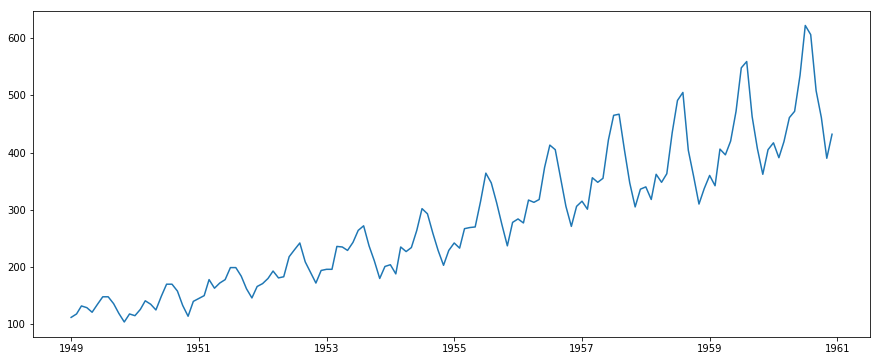

In [25]:
plt.plot(ts)

We can check stationarity using the following:

1. **Plotting Rolling Statistics:** We can plot the moving average or moving variance and see if it varies with time. By moving average/variance I mean that at any instant ‘t’, we’ll take the average/variance of the last year, i.e. last 12 months. But again this is more of a visual technique.
2. **Dickey-Fuller Test:** This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.

In [26]:
from statsmodels.tsa.stattools import adfuller


In [29]:
def test_stationarity(timeseries):
    # Determining rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)
    
    # Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='Black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    # Perform Dickey-Fuller Test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistics','p-value','#Lags used','Number of observations used'])
    for key, value in dftest[4].items():
        dfoutput['Critical value %s'%key] = value
    print(dfoutput)   

F:\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  app.launch_new_instance()
F:\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


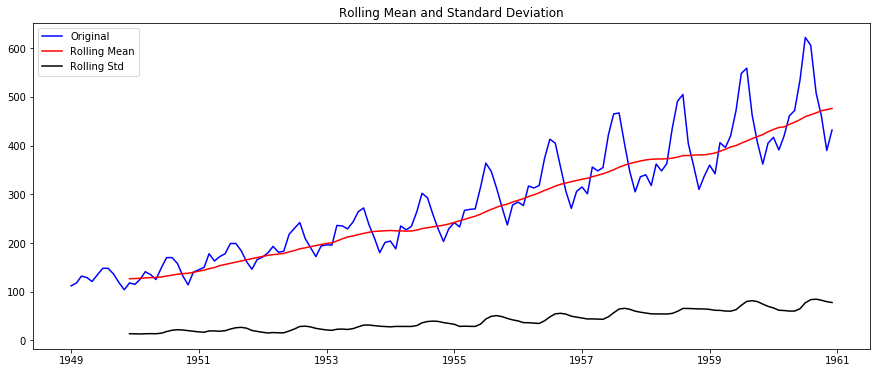

Results of Dickey-Fuller Test:
Test Statistics                  0.815369
p-value                          0.991880
#Lags used                      13.000000
Number of observations used    130.000000
Critical value 1%               -3.481682
Critical value 5%               -2.884042
Critical value 10%              -2.578770
dtype: float64


In [30]:
test_stationarity(ts)

Although the variation in standard deviation is small, mean is clearly increasing with time and this is **not a stationary** series. Also, the test statistic is way more than the critical values. Note that the **signed values should be compared** and not the absolute values.

# How to make a Time Series Stationary?


Lets understand what is making a TS non-stationary. There are 2 major reasons behind non-stationaruty of a TS:
1. Trend – varying mean over time. For eg, in this case we saw that on average, the number of passengers was growing over time.
2. Seasonality – variations at specific time-frames. eg people might have a tendency to buy cars in a particular month because of pay increment or festivals.

The underlying principle is to model or estimate the trend and seasonality in the series and remove those from the series to get a stationary series. Then statistical forecasting techniques can be implemented on this series. The final step would be to convert the forecasted values into the original scale by applying trend and seasonality constraints back.

## Estimating and Eliminating Trend

One of the first tricks to reduce trend can be **transformation**. For example, in this case we can clearly see that the there is a significant positive trend. So we can apply transformation which penalizes higher values more than smaller values. That can be done by taking a log, square root, cube root, etc. Lets take a log transform here for simplicity

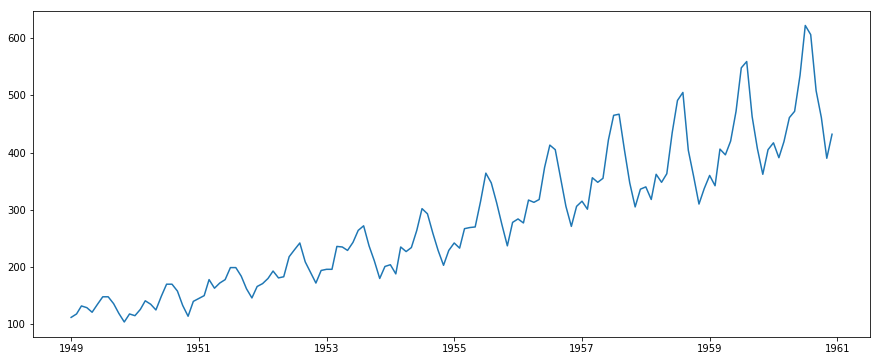

In [31]:
ts_log= np.log(ts)
plt.plot(ts)

we can use some techniques to estimate or model this trend and then remove it from the series. There can be many ways of doing it and some of most commonly used are:

1. **Aggregation** – taking average for a time period like monthly/weekly averages
2. **Smoothening** – taking rolling averages
3. **Polynomial Fitting** – fit a regression model

### Smoothening
In this approach, we take average of ‘k’ consecutive values depending on the frequency of time series. Here we can take the average over the past 1 year, i.e. last 12 values.

F:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  if __name__ == '__main__':


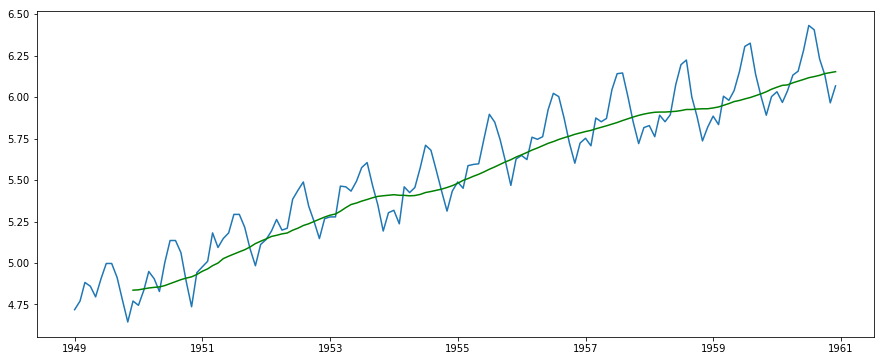

In [32]:
moving_avg = pd.rolling_mean(ts_log,12)
plt.plot(ts_log)
plt.plot(moving_avg, color='green')

Lets subtract the rolling mean from the original series. Note that since we are taking average of last 12 values, rolling mean is not defined for first 11 values. This can be observed as:

In [35]:
diff = ts_log - moving_avg
diff.head(12)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
Name: #Passengers, dtype: float64

F:\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  app.launch_new_instance()
F:\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


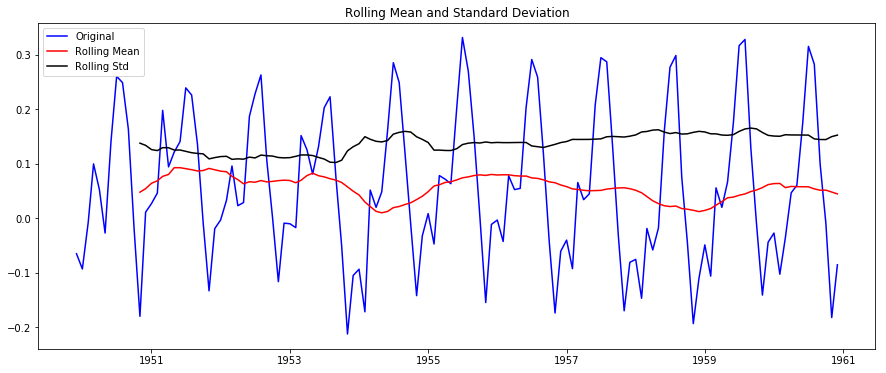

Results of Dickey-Fuller Test:
Test Statistics                 -3.162908
p-value                          0.022235
#Lags used                      13.000000
Number of observations used    119.000000
Critical value 1%               -3.486535
Critical value 5%               -2.886151
Critical value 10%              -2.579896
dtype: float64


In [36]:
# drop NaN values
diff.dropna(inplace=True)
test_stationarity(diff)

The rolling values appear to be varying slightly but there is no specific trend. Also, the test statistic is smaller than the 5% critical values so we can say with 95% confidence that this is a stationary series.

**Drawback:** The time-period has to be strictly defined. In this case we can take yearly averages but in complex situations like forecasting a stock price, its difficult to come up with a number. So we take a **weighted moving average** where more recent values are given a higher weight. There can be many technique for assigning weights. A popular one is **exponentially weighted moving average** where weights are assigned to all the previous values with a decay factor.

F:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(halflife=12,min_periods=0,adjust=True,ignore_na=False).mean()
  if __name__ == '__main__':


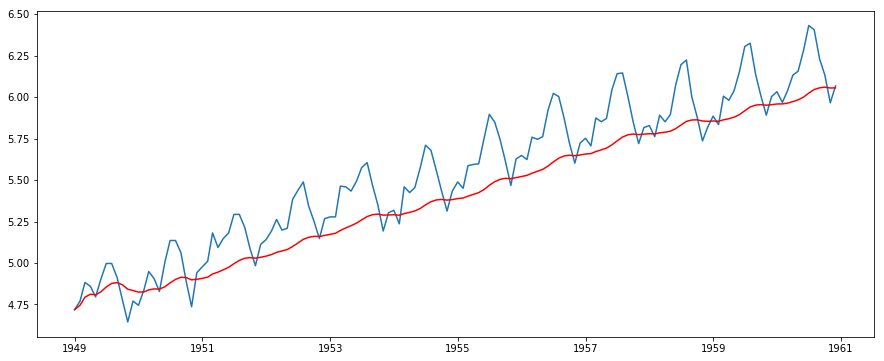

In [37]:
expweighted_avg= pd.ewma(ts_log, halflife=12)
plt.plot(ts_log)
plt.plot(expweighted_avg, color='red')

In [38]:
ewma_diff = ts_log - expweighted_avg
ewma_diff.head()

Month
1949-01-01    0.000000
1949-02-01    0.025339
1949-03-01    0.088967
1949-04-01    0.048028
1949-05-01   -0.012415
Name: #Passengers, dtype: float64

F:\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  app.launch_new_instance()
F:\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


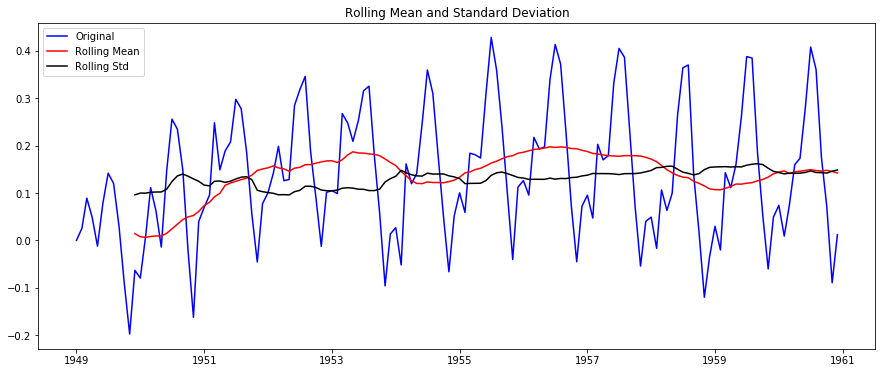

Results of Dickey-Fuller Test:
Test Statistics                 -3.601262
p-value                          0.005737
#Lags used                      13.000000
Number of observations used    130.000000
Critical value 1%               -3.481682
Critical value 5%               -2.884042
Critical value 10%              -2.578770
dtype: float64


In [39]:
test_stationarity(ewma_diff)

The test statistic is **smaller than the 1% critical value**, which is better than the previous case. Note that in this case there will be no missing values as all values from starting are given weights. So it’ll work even with no previous values.

## Eliminating Trend and Seasonality
Lets discuss two ways of removing trend and seasonality:

1. **Differencing** – taking the differece with a particular time lag
2. **Decomposition** – modeling both trend and seasonality and removing them from the model.

### Differencing
One of the most common methods of dealing with both trend and seasonality is **differencing**. In this technique, we take the difference of the observation at a particular instant with that at the previous instant. This mostly works well in improving stationarity. First order differencing:

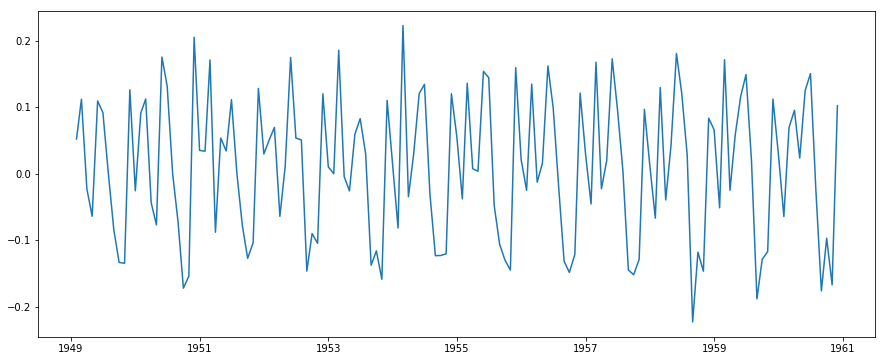

In [40]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

In [41]:
ts_log_diff.head()

Month
1949-01-01         NaN
1949-02-01    0.052186
1949-03-01    0.112117
1949-04-01   -0.022990
1949-05-01   -0.064022
Name: #Passengers, dtype: float64

F:\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  app.launch_new_instance()
F:\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


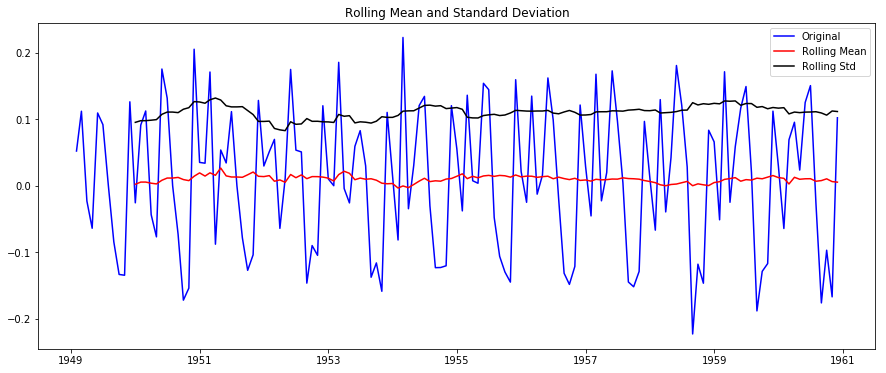

Results of Dickey-Fuller Test:
Test Statistics                 -2.717131
p-value                          0.071121
#Lags used                      14.000000
Number of observations used    128.000000
Critical value 1%               -3.482501
Critical value 5%               -2.884398
Critical value 10%              -2.578960
dtype: float64


In [42]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

We can see that the mean and std variations have small variations with time. Also, the Dickey-Fuller test statistic is less than the 10% critical value, thus the TS is stationary with 90% confidence. We can also take second or third order differences which might get even better results in certain applications. 

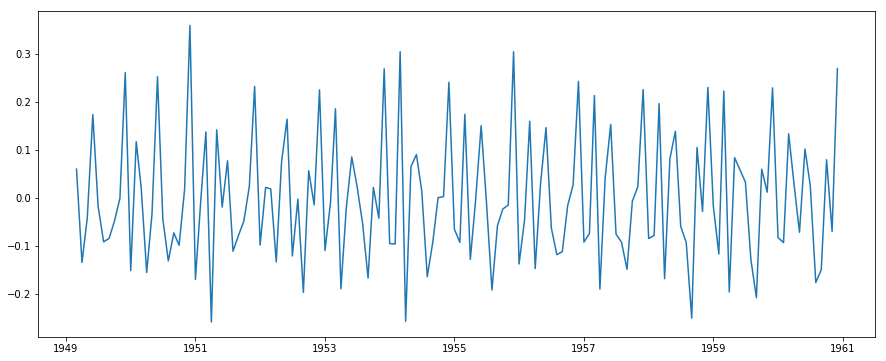

In [44]:
ts_log_diff2 = ts_log_diff - ts_log_diff.shift()
plt.plot(ts_log_diff2)

In [45]:
ts_log_diff2.head()

Month
1949-02-01         NaN
1949-03-01    0.059932
1949-04-01   -0.135107
1949-05-01   -0.041032
1949-06-01    0.173506
Name: #Passengers, dtype: float64

F:\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  app.launch_new_instance()
F:\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


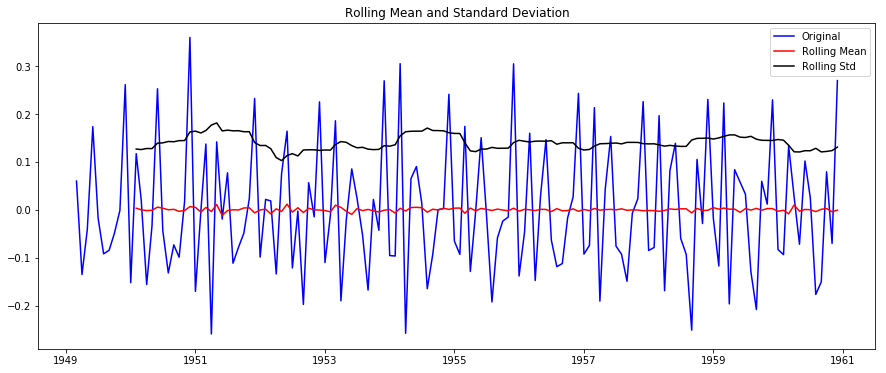

Results of Dickey-Fuller Test:
Test Statistics               -8.196629e+00
p-value                        7.419305e-13
#Lags used                     1.300000e+01
Number of observations used    1.280000e+02
Critical value 1%             -3.482501e+00
Critical value 5%             -2.884398e+00
Critical value 10%            -2.578960e+00
dtype: float64


In [46]:
ts_log_diff2.dropna(inplace=True)
test_stationarity(ts_log_diff2)

### Decomposing
In this approach, both trend and seasonality are modeled separately and the remaining part of the series is returned.

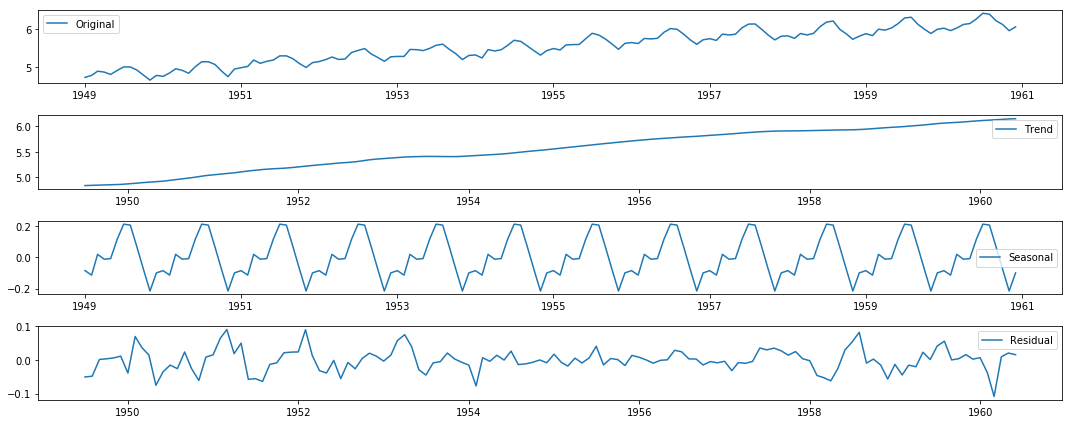

In [49]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='best')
plt.tight_layout()

In [50]:
ts_log_decom = residual
ts_log_decom.head()

Month
1949-01-01   NaN
1949-02-01   NaN
1949-03-01   NaN
1949-04-01   NaN
1949-05-01   NaN
Name: #Passengers, dtype: float64

F:\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  app.launch_new_instance()
F:\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


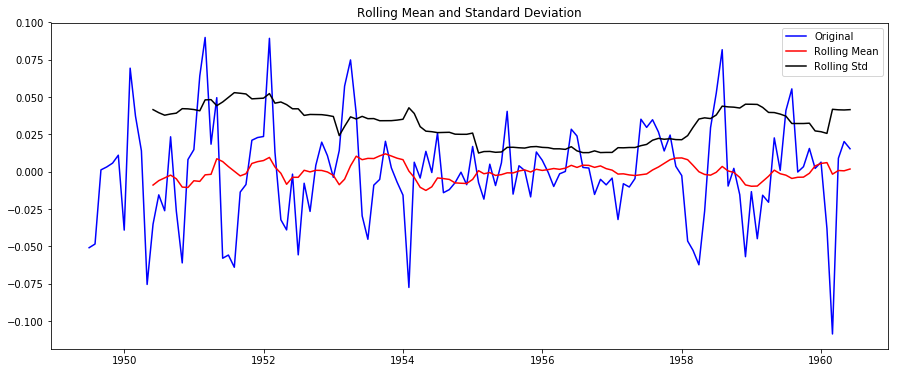

Results of Dickey-Fuller Test:
Test Statistics               -6.332387e+00
p-value                        2.885059e-08
#Lags used                     9.000000e+00
Number of observations used    1.220000e+02
Critical value 1%             -3.485122e+00
Critical value 5%             -2.885538e+00
Critical value 10%            -2.579569e+00
dtype: float64


In [51]:
ts_log_decom.dropna(inplace=True)
test_stationarity(ts_log_decom)

The Dickey-Fuller test statistic is **significantly lower than the 1% critical value**. So this TS is very close to stationary.

# Forecasting a time Series

Lets make model on the TS after differencing as it is a very popular technique. Also, its relatively easier to add noise and seasonality back into predicted residuals in this case. Having performed the trend and seasonality estimation techniques, there can be two situations:

1. A strictly stationary series with no dependence among the values. This is the easy case wherein we can model the residuals as white noise. But this is very rare.
2. A series with significant dependence among values. In this case we need to use some statistical models like **ARIMA** to forecast the data.

**ARIMA** stands for **Auto-Regressive Integrated Moving Averages**. The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. The predictors depend on the **parameters (p,d,q)** of the ARIMA model:

1. **Number of AR (Auto-Regressive) terms (p)**: AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
2. **Number of MA (Moving Average) terms (q)**: MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.
3. **Number of Differences (d)**: These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.

An importance concern here is how to determine the value of ‘p’ and ‘q’. We use two plots to determine these numbers. Lets discuss them first.
1. **Autocorrelation Function (ACF)**: It is a measure of the correlation between the the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).
2. **Partial Autocorrelation Function (PACF)**: This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. For example, at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.

In [53]:
# ACF and PACF plots
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(ts_log_diff, nlags = 20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

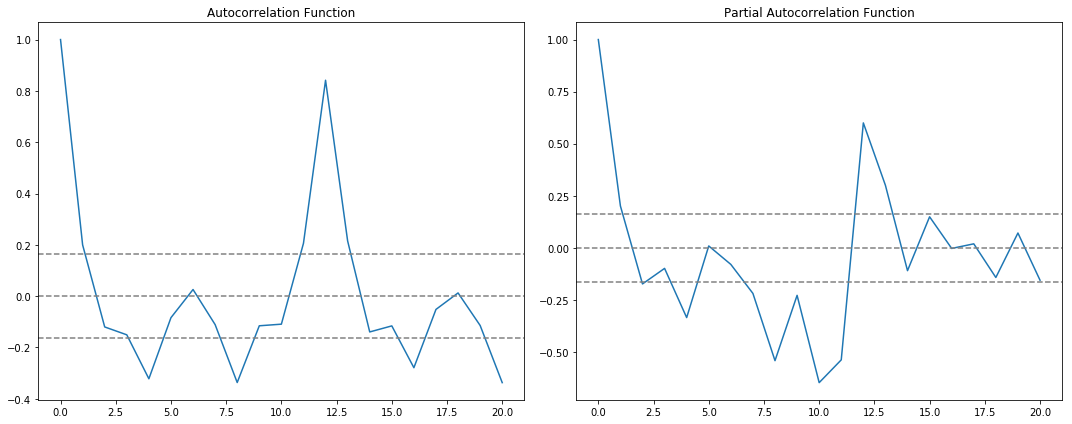

In [55]:
# plot acf
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

# plot pacf
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In this plot, the two dotted lines on either sides of 0 are the confidence interevals. These can be used to determine the ‘p’ and ‘q’ values as:

1. p – The lag value where the PACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case p=2.
2. q – The lag value where the ACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case q=2.

In [56]:
from statsmodels.tsa.arima_model import ARIMA

## AR Model

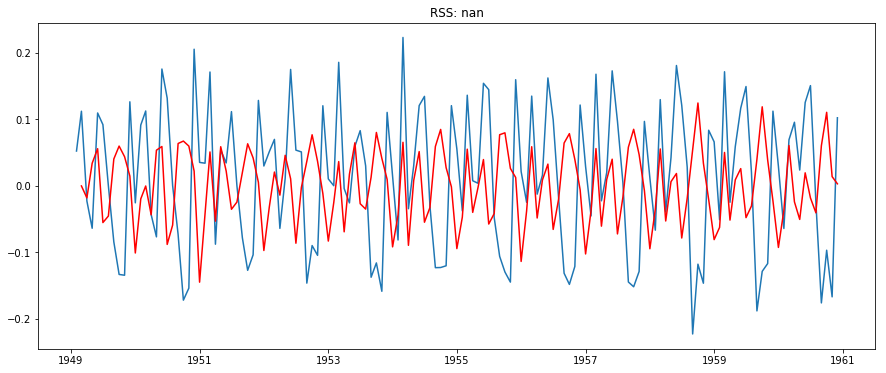

In [57]:
model= ARIMA(ts_log_diff, order=(2,1,0))
results_AR = model.fit(disp=-1)
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

## MA Model

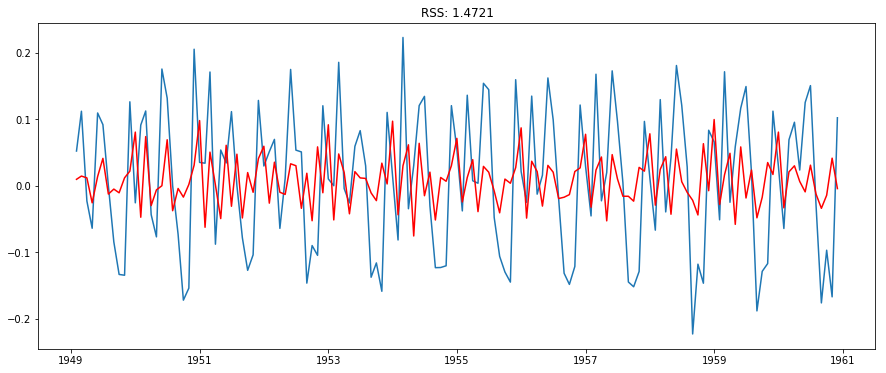

In [58]:
model = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

## Combined Model

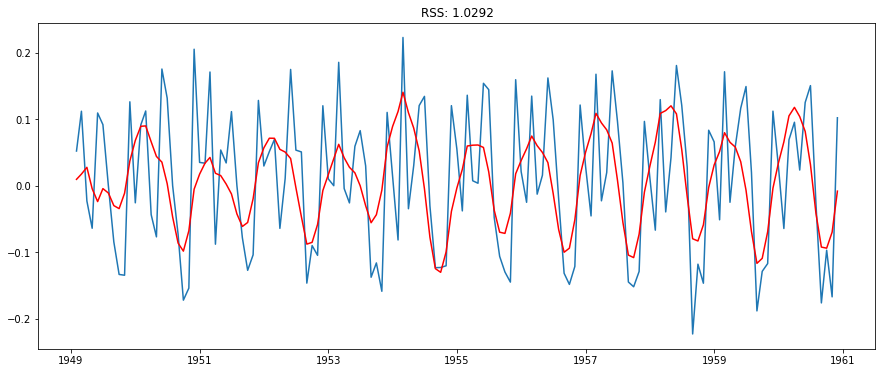

In [59]:
model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

Here we can see that the AR and MA models have almost the same RSS but combined is significantly better.

# Taking it back to original scale
First step would be to store the predicted results as a separate series and observe it.

In [61]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64


Notice that these start from ‘1949-02-01’ and not the first month. Why? This is because we took a lag by 1 and first element doesn’t have anything before it to subtract from. The way to convert the differencing to log scale is to add these differences consecutively to the base number. An easy way to do it is to first determine the cumulative sum at index and then add it to the base number.

In [62]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64


Next we’ve to add them to base number. For this lets create a series with all values as base number and add the differences to it. This can be done as:

In [63]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

Here the first element is base number itself and from thereon the values cumulatively added. Last step is to take the exponent and compare with the original series.

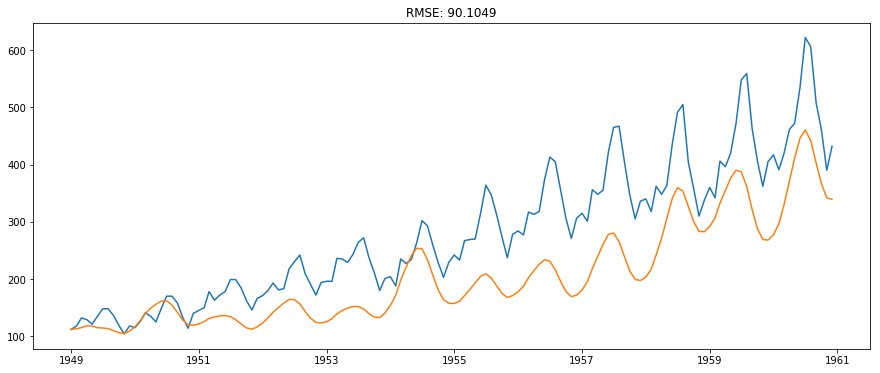

In [64]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))